In [1]:
# import os
# os.chdir("./unet")
from config import *
from unet_config import Config
import os
import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = ''

Using TensorFlow backend.


In [2]:
config_unet = Config()

In [4]:
def get_image_data(num_images_to_get=32, normalise=True, image_folder = TRAIN_IMAGE_FOLDER):
    # Get list of files
    satellite_images = glob.glob(image_folder + SAT_IMAGE_FOLDER + "/0/*.png")
    if normalise:
        # first provide a sample of images for featurewise normalisation
        X_sample, y_sample = next(get_image_data(num_images_to_get=1000, normalise=False))

        mean_sat_color = np.mean(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)
        variance_sat_color = np.var(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)

        del X_sample
        del y_sample

    while True:
        np.random.shuffle(satellite_images)

        # Preallocate array of image stacks
        satellite_stacked = np.zeros((num_images_to_get, 224, 224, 3), dtype=np.float32)
        mask_stacked = np.zeros((num_images_to_get, 224, 224, 1), dtype=np.float32)

        for i, image in enumerate(satellite_images[:num_images_to_get]):
            image = image.split("/")[-1]
            satellite_stacked[i] = np.array(Image.open(image_folder + SAT_IMAGE_FOLDER + "/0/" + image))
            mask_stacked[i] = np.array(Image.open(image_folder + MASK_IMAGE_FOLDER + "/0/" + image)).reshape(224,224, 1)/255.0

        if normalise:
            satellite_stacked = (satellite_stacked - mean_sat_color)/np.sqrt(variance_sat_color)
            #mask_stacked = (mask_stacked - mean_mask_color)/np.sqrt(variance_mask_color)
        yield satellite_stacked, mask_stacked

In [30]:
X_sample, y_sample = next(get_image_data(num_images_to_get=1000, normalise=False))

mean_sat_color = np.mean(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)
variance_sat_color = np.var(X_sample.reshape(X_sample.shape[0]*X_sample.shape[1]*X_sample.shape[2], 3), axis=0)

del X_sample
del y_sample

In [50]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)



In [90]:
from model import get_vgg_7conv
import metrics

model = get_vgg_7conv(config_unet.ISZ, config_unet.N_CHANNELS, config_unet.NUM_CLASSES)

model.load_weights(os.path.join('../model.h5'))

In [88]:
test_data = get_image_data(1, True, image_folder=TEST_IMAGE_FOLDER)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


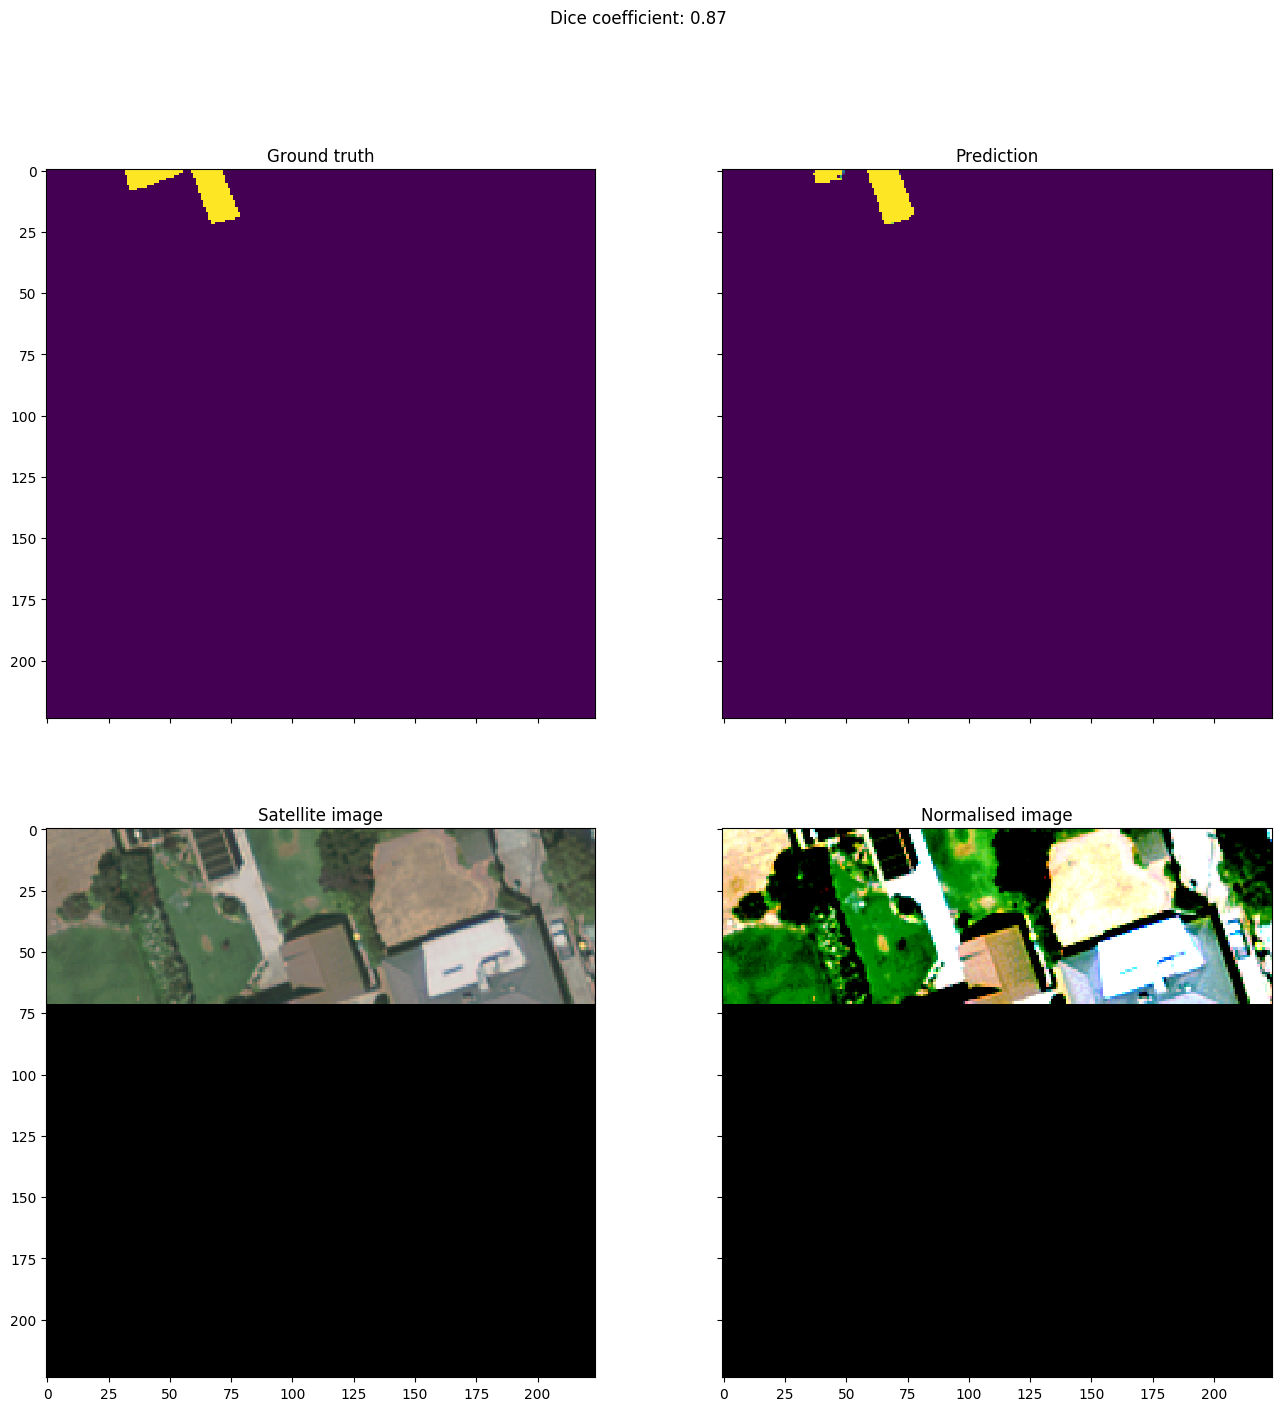

In [93]:
## Testing the model
sat, mask = next(test_data)
model_prediction = model.predict(sat).reshape(224,224)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(16,16), dpi=100)
f.suptitle('Dice coefficient: {0:0.2f}'.format(dice_coef(mask[0], model_prediction)))
ax3.imshow((sat[0]*np.sqrt(variance_sat_color) + mean_sat_color).astype(int))
ax3.set_title("Satellite image")
ax4.imshow(sat[0])
ax4.set_title("Normalised image")
ax1.imshow(mask[0].reshape(224,224))
ax1.set_title("Ground truth")
ax2.imshow(model_prediction)
ax2.set_title("Prediction")
plt.show()